In [1]:
#Broker imports:
import py_at_broker as pab
from IPython.display import clear_output

import pylab as pl
import pickle as p
import matplotlib.pyplot as plt
%matplotlib inline
b = pab.broker()

%load_ext autoreload
%autoreload 2
from toolbox import data_processing as dp
from toolbox import movementtoolbox as mt 
#Non broker imports:

from IPython import display
import math as math
import pandas as pd
import time
import cv2
import numpy as np
%load_ext autoreload
%autoreload 2
from toolbox import kinematic_mapping as km
from robo_cheesecake.engine import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%load_ext autoreload
%autoreload 2
from toolbox import object_detection_toolbox as odt
import os
import tensorflow as tf

from object_detection.utils import visualization_utils as vis_util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dlrc1/Documents/models/research/object_detection/utils/visualization_utils.py:27: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/dlrc1/.virtualenvs/dlrc/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/dlrc1/.virtualenvs/dlrc/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/dlrc1/.virtualenvs/dlrc/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    

import SLRobot
from scipy.interpolate import interp1d
from scipy import interpolate

pgain_null = 0.002 * np.array([600.0, 600.0, 600.0, 600.0, 250.0, 150.0, 50.0], dtype=np.float64)

# Null-space theta configuration
target_th_null = np.zeros(7, dtype=np.float64)
target_th_null[3] = -1.55
target_th_null[5] = 1.9


def quatToEulerAngles(quat):

    eulerAngles = np.array([0.0]*3)
    threshold = 0.001
    qw = quat[0]
    qx = quat[1]
    qy = quat[2]
    qz = quat[3]  

    heading = np.arctan2(2.0*qy*qw-2.0*qx*qz , 1.0 - 2.0*qy*qy - 2.0*qz*qz)
    attitude = np.arcsin(2.0*qx*qy + 2.0*qz*qw)
    bank = np.arctan2(2.0*qx*qw-2.0*qy*qz , 1.0 - 2.0*qx*qx - 2.0*qz*qz)

    if (qx*qy + qz*qw - 0.5)*(qx*qy + qz*qw - 0.5) < threshold:
        heading = 2.0 * np.arctan2(qx,qw)
        bank = 0

    if (qx*qy + qz*qw + 0.5)*(qx*qy + qz*qw + 0.5) < threshold:
        heading = -2.0 * np.arctan2(qx,qw)
        bank = 0

    eulerAngles[0] = attitude
    eulerAngles[1] = heading
    eulerAngles[2] = bank

    return(eulerAngles)





def inverse_kin_6d(c_pos,q):

    J_reg = 1e-8

    # initialize the position
    J_w = np.diag([50, 50, 25, 10, 10, 5, 1])

    # compute the velocity in joint space and update the joint position
    qi = []
    EF_=[]
    qi.append(q)
    results_ =[]
    c_vel_all = []

    #while 1:
    plt.figure()

    for t in np.arange(100000):
        
        EF_FK = SLRobot.FK(np.array([q]))
        #print(EF_FK[0,50:56])
        c_vel = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.01])*(c_pos - EF_FK[0,50:56])

        #print(c_vel)
        J = SLRobot.Jacobian(np.array([q]), 6)
        target_th_null_out  = target_th_null
        
        A = J.dot(J_w).dot(J.transpose())
        A += J_reg * np.eye(6)

        qd_null = pgain_null * (target_th_null_out - q)
        qd_d = np.linalg.solve(A, c_vel - J.dot(qd_null))
        qd_d = J_w.dot(J.transpose()).dot(qd_d) + qd_null

        q = q + 0.002*qd_d

        #set the joint range
        mask_max = q > np.pi
        mask_min = q<-np.pi
        q[mask_max] = q[mask_max] - 2*np.pi
        q[mask_min] = q[mask_min] + 2*np.pi

        qi.append(q)
        EF_.append(EF_FK[0,50:56])
        c_vel_all.append(c_vel)

        # times the arrary to scale the orientation range.
        error_ = np.sqrt(np.sum(np.square(np.array([1.0, 1.0, 1.0, 0.08, 0.08, 0.08])*(c_pos-EF_FK[0,50:56]))))
        #print(error_)
        if error_ <0.0080:

            break
    
    print('error:', error_)

    qi = np.array(qi)
    # for debug    
    plt.plot(qi)

    EF_ = np.array(EF_)
    c_vel_all = np.array(c_vel_all)

    return qi[-1], EF_, qi, c_vel_all


# This is a grasping point recorded by Alexj and Felix
grasp_pt_quat = np.array([ 0.6801316 ,  0.14607485,  0.07193319,  0.37495322,  0.55747047, 0.20780073,  0.58338235])
grasp_pt_angles = quatToEulerAngles(np.concatenate([grasp_pt_quat[-2:-1], grasp_pt_quat[3:6]])) #(np.array([0.37495322,  0.55747047, 0.20780073,  0.58338235]))
print(np.concatenate([grasp_pt_quat[-2:-1], grasp_pt_quat[3:6]]))
grasp_pt = np.concatenate([grasp_pt_quat[:3], grasp_pt_angles])

q = target_th_null

#input_EF = np.array([0.6801316 ,  0.14607485,  0.07193319,  0.52870199,  0.25408186, -0.11936578])
input_EF = grasp_pt
print(input_EF)
j_ik = inverse_kin_6d(input_EF,q)
end_pos=j_ik[0]

EF_FK = SLRobot.FK(np.array([end_pos]))

print('desired c pose:', input_EF)
print('c pose:', EF_FK[0,50:56])

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = '../faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/home/dlrc1/Documents/models/research/object_detection/data', 'mscoco_label_map.pbtxt')

with tf.device('/device:GPU:0'):
    detection_graph = tf.Graph()
    odt.load_model(PATH_TO_FROZEN_GRAPH, detection_graph)
    category_index = odt.create_category_index(PATH_TO_LABELS)
    with detection_graph.as_default() as graph:
        tensor_dict = odt.create_tensor_dict(['num_detections', 'detection_boxes', 'detection_scores',
        'detection_classes', 'detection_masks'])
    sess = tf.Session(graph=detection_graph)

In [3]:
b.request_signal("franka_lidar", pab.MsgType.franka_lidar)

True

In [4]:
b.register_signal('franka_target_pos', pab.MsgType.target_pos)

Address broker could not acceppt the offered signal franka_target_pos. Is there another signal with the same name? Trying to reconnect
Reconnection to signal <franka_target_pos> successful


True

In [5]:
b.register_signal("franka_gripper", pab.MsgType.gripper_cmd)

Address broker could not acceppt the offered signal franka_gripper. Is there another signal with the same name? Trying to reconnect
Reconnection to signal <franka_gripper> successful


True

In [6]:
b.request_signal("franka_state", pab.MsgType.franka_state, True)

current_counter=0

/home/dlrc1/.virtualenvs/dlrc/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


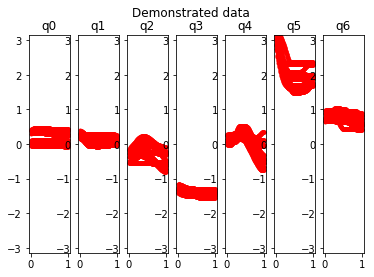

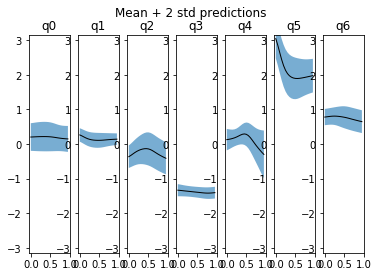

In [7]:
def PredZ(z):
    return RobotSaysHi.GeneratePrediction(w=RobotSaysHi.estimate_m, Z=z)[1]

df_generated, N=robotoolbox.PrepareData('JointsFinalPresentation_take3_PanningOverApple.p')

params = {'D' : 7, 'K' : 5, 'N' : N}
RobotSaysHi=ProMP(identifier='RobotSaysHi', TrainingData=df_generated, params=params)
RobotSaysHi.RegularizedLeastSquares() #Choice for l from [1]
RobotSaysHi.GenerateDemoPlot(xvariable="Phases")  
RobotSaysHi.MeanAndStdPredictionPlot(factor=2)
MaxTime=6
samples=1  




def FollowTrajectory(Q, record=False, df=[]):
    global current_counter

    sleep_time = samples
    go_time = 1.8*samples
    for idxq, Q_pos in enumerate(Q):

        #print(Q_pos)
        frame=current_counter+1
        target_msg, current_counter = mt.create_message(counter=frame, ctrl_t = 1, pos = Q_pos, go_time=go_time)
        b.send_msg('franka_target_pos', target_msg)
        
        if record: 
            target_time=time.time()
            while (time.time()-target_time<=sleep_time):
                state_msg = b.recv_msg("franka_state", 0)
                lidar_msg = b.recv_msg("franka_lidar", 0)
                df2 = pd.DataFrame([state_msg.get_timestamp(), state_msg.get_j_pos(), state_msg.get_j_vel(), state_msg.get_c_pos(), 
                    lidar_msg.get_timestamp(), lidar_msg.get_data()],cols)
                df = df.append(df2.T, ignore_index = True)
                time.sleep(0.2)
        else:
            time.sleep(sleep_time)
            
            
        if idxq==0:
            pass
        
    return df

            #time.sleep(2)
        





dumped pickle iter53


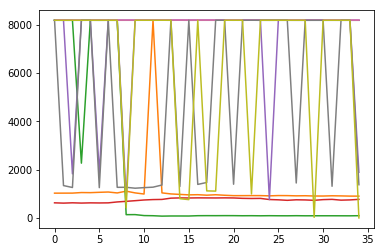

-1


KeyboardInterrupt: 

In [8]:
import numpy.random as npr

#Q_des=end_pos

#w_des=RobotSaysHi.Condition_JointSpace(Qtarget=[RobotSaysHi.GetStartPoint(w=RobotSaysHi.estimate_m), Q_des], Ztarget=[0,z])        
#w_des=RobotSaysHi.Condition_JointSpace(Qtarget=[RobotSaysHi.GetStartPoint(w=RobotSaysHi.estimate_m),PredZ(0.3) ,PredZ(0.35) , Q_des], Ztarget=[0,0.3,0.35,z])        
filename = 'panning_'
cols = ['timestamp_franka', 'joint_pos', 'joint_vel', 'endeff_pos', 'timestamp_lidar', 'lidar_data']
df = pd.DataFrame(columns = cols)
polarity=1
iters = 25
while True:
    w_sampled=npr.multivariate_normal(RobotSaysHi.estimate_m,RobotSaysHi.estimate_sigma)
    T, Q= RobotSaysHi.GetJointData(w= w_sampled, robotrate=samples, MaxTime=MaxTime)
    if polarity==-1:
        Q=np.flip(Q, axis=0)
    #robotoolbox.PlotTrajectory(T, Q)
    #plt.show()
    
    df = pd.DataFrame(columns = cols)
    df = FollowTrajectory(Q, record=True, df=df)
    p.dump(df, open(filename + str(iters) + '.p', 'wb'))
    print('dumped pickle iter{}'.format(iters))
    
    data = p.load(open(filename + str(iters) + '.p', 'rb'))
    plt.plot(np.array(list(data['lidar_data'].values)))
    plt.show()
    polarity=-polarity
    print(polarity)
    time.sleep(2)
    iters+= 1
    clear_output(wait = True)



In [ ]:
lidar_msg = b.recv_msg("franka_lidar", 1)
lidar_msg.get_data()